In [1]:
from pysme.synthesize import synthesize_spectrum
from pysme.linelist.linelist import LineList
from pysme.linelist.vald import ValdFile
from pysme.sme import SME_Structure
from pysme.util import vac2air
from pysme.solve import solve
from pysme.abund import Abund
from pysme import util

from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import sys
import os

warnings.filterwarnings('ignore')

In [2]:
os.chdir('/home/fgran/iSpec/')
import ispec
sys.path.append('/home/fgran/iSpec/')

In [3]:
os.environ['NUMEXPR_MAX_THREADS'] = '80' #change this number using the correct number of cores/threads in jupyter.slurm

In [4]:
#Move to the correct directory: Pristine-UVES
os.chdir('/store/teams/cosmos/fgran/data/Pristine-UVES/')

In [6]:
#Prepare catalogue ingestion
uves = pd.read_csv('tmp_merged/UVES_p111_p112_pristinedr1_xgboost_logg_atm_uncs_fe.csv')

In [9]:
wmin_blue = 4000 #AA
wmax_blue = 4500 #AA
wmin_red1 = 4730 #AA
wmax_red1 = 5700 #AA
wmin_red2 = 5850 #AA
wmax_red2 = 6800 #AA

In [10]:
#pysme that only need to be executed once
linelist = ValdFile('linelist/3800-6800_long.lin')
print('Number of lines in the linelist: %d' %linelist.species.size)

linelist = linelist[((linelist.wlcent > wmin_blue) & (linelist.wlcent < wmax_blue) | \
                     (linelist.wlcent > wmin_red1) & (linelist.wlcent < wmax_red1) | \
                     (linelist.wlcent > wmin_red2) & (linelist.wlcent < wmax_red2))]

delta_H_line = 10. #AA
delta_line = 1. #AA
wl_G_band = 4300 #AA
delta_G_band = 40. #AA

wl_Halpha_line = 6562.79 #AA
delta_Halpha = 10.0 #AA
wl_Hbeta_line = 4861.35 #AA
delta_Hbeta = 10.00 #AA

[2024-11-15 13:33:05,605] [INFO] [vald:loads:173]: Loading VALD file linelist/3800-6800_long.lin


INFO - Loading VALD file linelist/3800-6800_long.lin


[2024-11-15 13:33:05,977] [WARNING] [vald:parse_references:530]: Could not find citation key: SNave
[2024-11-15 13:33:05,978] [DEBUG] [vald:parse_references:531]: 'snave'
[2024-11-15 13:33:05,979] [WARNING] [vald:parse_references:530]: Could not find citation key: NIST22
[2024-11-15 13:33:05,980] [DEBUG] [vald:parse_references:531]: 'nist22'
[2024-11-15 13:33:05,980] [WARNING] [vald:parse_references:530]: Could not find citation key: SugCor
[2024-11-15 13:33:05,981] [DEBUG] [vald:parse_references:531]: 'sugcor'
[2024-11-15 13:33:05,981] [WARNING] [vald:parse_references:530]: Could not find citation key: TPSb
[2024-11-15 13:33:05,982] [DEBUG] [vald:parse_references:531]: 'tpsb'
[2024-11-15 13:33:05,982] [WARNING] [vald:parse_references:530]: Could not find citation key: LBT
[2024-11-15 13:33:05,983] [DEBUG] [vald:parse_references:531]: 'lbt'
[2024-11-15 13:33:05,983] [WARNING] [vald:parse_references:530]: Could not find citation key: Kra2010
[2024-11-15 13:33:05,984] [DEBUG] [vald:parse

WARNING - Could not find citation key: SNave
WARNING - Could not find citation key: NIST22
WARNING - Could not find citation key: SugCor
WARNING - Could not find citation key: TPSb
WARNING - Could not find citation key: LBT
WARNING - Could not find citation key: Kra2010
WARNING - Could not find citation key: TPSa
Number of lines in the linelist: 2902


In [11]:
#Create solar scaled atmosphere with [alpha/Fe] = +0.4
solar = SME_Structure()
solar.abund = Abund(0.0, 'asplund2009')

abund = solar.abund.pattern
abund['O'] = abund['O'] + 0.4
abund['Ne'] = abund['Ne'] + 0.4
abund['Mg'] = abund['Mg'] + 0.4
abund['Si'] = abund['Si'] + 0.4
abund['S'] = abund['S'] + 0.4
abund['Ar'] = abund['Ar'] + 0.4
abund['Ca'] = abund['Ca'] + 0.4
abund['Ti'] = abund['Ti'] + 0.4

In [13]:
elems_to_include = ['Fe 1', 'Fe 2', 'Mg 1', 'Ti 1', 'Ti 2', 'Na 1']
linelist = linelist[np.asarray([True if elem in elems_to_include else False for elem in linelist.species])]

In [14]:
print(np.unique(linelist.species))
print('Nro de lineas', linelist.species.size)

['Fe 1' 'Fe 2' 'Mg 1' 'Na 1' 'Ti 1' 'Ti 2']
Nro de lineas 811


In [25]:
mask_cont = pd.read_csv('continuum_model/sme_cont_mask', sep=' ', names=['wl', 'mask_values'])

In [26]:
def sme_init(wave, spec, uncs, teff, logg, monh, vmic, vmac, vsini, abund, vrad_flag, linelist, ipress, vrad_bounds, elems_to_include):

    #SME definitions
    sme = SME_Structure()

    sme.ipres, sme.iptype, sme.gam6, sme.h2broad = ipress, 'gauss', True, True
    sme.atmo.source, sme.atmo.method, sme.atmo.geom = 'marcs2012s_t2.0.sav', 'grid', 'SPH'

    sme.accxt, sme.accgt, sme.accft = tol, tol, tol
    sme.leastsquare3_ftol, sme.leastsquares_gtol, sme.leastsquares_xtol = tol, tol, tol
    sme.accwi, sme.accrt, sme.clim, sme.chirat = tol, tol, tol, tol
    sme.vrad_bounds = vrad_bounds

    # Redirect output to logs/RUN*/*.txt
    util.start_logging(log_file='logs/UVES_atm.txt', level='ERROR')

    sme.cscale_flag = 'constant'
    # sme.cscale = 1.0
    sme.cscale_type = 'mask'
    sme.fitresults.maxiter = 100

    sme.wave = wave
    sme.spec = spec
    sme.uncs = uncs

    # The mask values are: 0: bad pixel, 1: line pixel, 2: continuum pixel
    line_regions = mask_cont.mask_values.values
    ll_mask = np.zeros(linelist.species.size).astype(bool)
    
    for wline, mask_species in linelist[['wlcent', 'species']]:
        if mask_species in elems_to_include:
            idx_ = (sme.wave.data > wline-delta_line) & (sme.wave.data < wline+delta_line)
            line_regions[idx_] = 1
            
            ll_mask[(linelist.wlcent > wline-delta_line) & (linelist.wlcent < wline+delta_line)] = True
            continue
        
    for wline, mask_species in linelist[['wlcent', 'species']]:
        #Hydrogen lines
        if 'H 1' == mask_species:
            idx_ = (sme.wave.data > wline-delta_Halpha) & (sme.wave.data < wline+delta_Halpha)
            line_regions[idx_] = 0
    del idx_
    
    #G-band and CaHK regions
    # line_regions[(sme.wave.data > wl_G_band-delta_G_band) & (sme.wave.data < wl_G_band+delta_G_band)] = 0
    # line_regions[(sme.wave.data > wl_CaHK_band-delta_CaHK_band) & (sme.wave.data < wl_CaHK_band+delta_CaHK_band)] = 0
    # line_regions[sme.wave.data < 4000] = 0
    #Merge all the line_regions as int
    line_regions = line_regions.astype(int)
    line_regions[sme.spec.data == 0.0] = 0
    sme.mask = line_regions
    del line_regions

    sme.linelist = linelist[ll_mask]
    del ll_mask

    #Abundance scaling to create realistic synthetics
    sme.abund = abund
    #RV determination for each chip
    sme.vrad_flag = vrad_flag

    #input guesses from xgboost
    sme.teff = teff
    sme.logg = logg
    sme.monh = monh
    sme.vmic = vmic
    sme.vmac = vmac
    sme.vsini = vsini
    
    return sme

In [27]:
def sme_parallel(i, input_row, elems_to_include, vrad_flag, ipress, tol=1e-2):

    #Load data to create SME structures
    blue_spec = ispec.read_spectrum('norm_RV_corr/%s/blue_%s' %(input_row.run, input_row.blue_file))
    blue_spec.waveobs = blue_spec.waveobs * 10.
    blue_spec.err[blue_spec.err == 0.0] = 1.0
    red1_spec = ispec.read_spectrum('norm_RV_corr/%s/red1_%s' %(input_row.run, input_row.red_file))
    red1_spec.waveobs = red1_spec.waveobs * 10.
    red1_spec.err[red1_spec.err == 0.0] = 1.0
    red2_spec = ispec.read_spectrum('norm_RV_corr/%s/red2_%s' %(input_row.run, input_row.red_file))
    red2_spec.waveobs = red2_spec.waveobs * 10.
    red2_spec.err[red2_spec.err == 0.0] = 1.0

    wave = [blue_spec.waveobs[(blue_spec.waveobs > wmin_blue) & (blue_spec.waveobs < wmax_blue)], 
            red1_spec.waveobs[(red1_spec.waveobs > wmin_red1) & (red1_spec.waveobs < wmax_red1)],
            red2_spec.waveobs[(red2_spec.waveobs > wmin_red2) & (red2_spec.waveobs < wmax_red2)]]
    spec = [blue_spec.flux[(blue_spec.waveobs > wmin_blue) & (blue_spec.waveobs < wmax_blue)],
            red1_spec.flux[(red1_spec.waveobs > wmin_red1) & (red1_spec.waveobs < wmax_red1)],
            red2_spec.flux[(red2_spec.waveobs > wmin_red2) & (red2_spec.waveobs < wmax_red2)]]
    uncs = [1./blue_spec.err[(blue_spec.waveobs > wmin_blue) & (blue_spec.waveobs < wmax_blue)],
            1./red1_spec.err[(red1_spec.waveobs > wmin_red1) & (red1_spec.waveobs < wmax_red1)],
            1./red2_spec.err[(red2_spec.waveobs > wmin_red2) & (red2_spec.waveobs < wmax_red2)]]

    del blue_spec, red1_spec, red2_spec

    #input guesses from xgboost
    teff = input_row.teff
    logg = input_row.logg
    monh = input_row.monh
    vmic = input_row.vmic
    vmac = input_row.vmac
    vsini = 10.

    sme = sme_init(wave, spec, uncs, teff, logg, monh, vmic, vmac, vsini, abund, vrad_flag, linelist, ipress = ipress, vrad_bounds = (-5,5), elems_to_include = elems_to_include)
    del wave, spec, uncs
   
    #Do the heavy lifting with fix logg from distances+BC
    fitparameters = ['vmac', 'vsini']
    sme = solve(sme, fitparameters)

    vmac, evmac_sme, evmac_fit = sme.vmac, sme.fitresults.uncertainties[0], sme.fitresults.fit_uncertainties[0]
    vsini, evsini_sme, evsini_fit = sme.vsini, sme.fitresults.uncertainties[1], sme.fitresults.fit_uncertainties[1]

    sme.save('sme_save/UVES_rr_%s' %input_row.spec_id)
    del sme

    columns = ['spec_id', 'vmac', 'evmac_sme', 'evmac_fit', 'vsini', 'evsini_sme', 'evsini_fit']
    data_to_write = np.vstack((input_row.spec_id, vmac, evmac_sme, evmac_fit, vsini, evsini_sme, evsini_fit)).T

    del vmac, evmac_sme, evmac_fit, vsini, evsini_sme, evsini_fit

    pd.DataFrame(data=data_to_write, columns=columns).to_csv('tmp_atm/UVES_rr_%s.csv' %input_row.spec_id, index=False, header=False)
    del data_to_write

    return

In [28]:
vrad_flag = 'each'
ipress = 42000
tol = 1e-3

In [29]:
%%time

#Single execution for all stars in uves
uves = pd.read_csv('tmp_merged/UVES_p111_p112_pristinedr1_xgboost_logg_atm_uncs_fe.csv')
uves = uves.query('vmac > 20')
Parallel(n_jobs=2, verbose=5)(delayed(sme_parallel)(i, input_row, elems_to_include=elems_to_include, vrad_flag=vrad_flag, ipress=ipress, tol=tol) for i, input_row in uves.iterrows())

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


CPU times: user 34.4 ms, sys: 26.1 ms, total: 60.5 ms
Wall time: 9min


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  9.0min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  9.0min finished


[None, None]

In [53]:
sme_rr1 = SME_Structure.load('sme_save/UVES_rr_6859555838257273600_3573691_106.sme')
sme_rr2 = SME_Structure.load('sme_save/UVES_rr_6859555838257273600_3573691_115.sme')

[2024-11-15 14:38:56,542] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_rr_6859555838257273600_3573691_106.sme
[2024-11-15 14:38:56,575] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_rr_6859555838257273600_3573691_115.sme


INFO - Loading SME file sme_save/UVES_rr_6859555838257273600_3573691_106.sme
INFO - Loading SME file sme_save/UVES_rr_6859555838257273600_3573691_115.sme


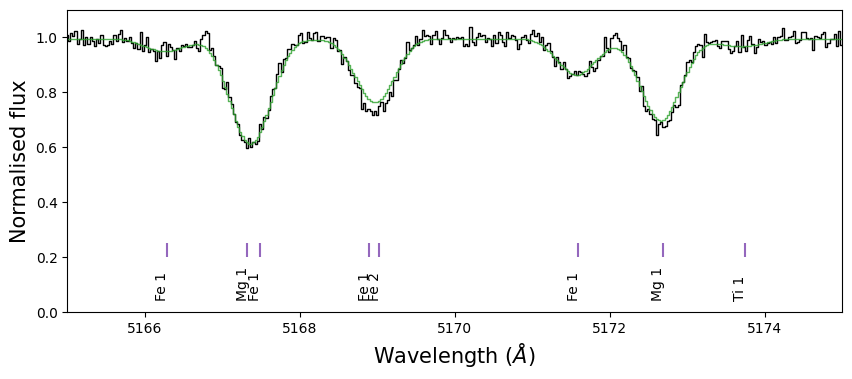

In [83]:
plt.figure(figsize=(10,4), dpi=100)

plt.step(sme_rr1.wave.data, sme_rr1.spec.data, lw=1, color='k')
plt.step(sme_rr1.wave.data, sme_rr1.synth.data, color='C2', lw=1, alpha=0.8)

# plt.step(sme_rr2.wave.data, sme_rr2.spec.data, lw=1, color='k')
# plt.step(sme_rr2.wave.data, sme_rr2.synth.data, color='C2', lw=1, alpha=0.8)

for wline, species, depth in linelist[['wlcent', 'species', 'depth']]:
    if 'H 1' in species:
        continue
    # if (depth > 0.85) | (depth < 0.15):
    #     continue
    plt.vlines(wline, 0.2, 0.25, color='C4')
    plt.annotate(text='%s' %species, xy=(wline-0.15, 0.05), rotation=90)
    # plt.annotate(text='%2.3f' %depth, xy=(wline-0.15, 0.5), rotation=90)
    
# plt.scatter(sme.wave.data, sme.mask.data, color='grey', s=5)

plt.xlabel(r'Wavelength ($\AA$)', size=15)
plt.ylabel(r'Normalised flux', size=15)

# plt.xlim(4025, 4035)
# plt.xlim(4330, 4350)
# plt.xlim(4270, 4320)
# plt.xlim(4200, 4220)
# plt.xlim(4125, 4135)
# plt.xlim(4172, 4190)
# plt.xlim(4220, 4240)
# plt.xlim(4460, 4470)
# plt.xlim(5165, 5190)
plt.xlim(5165, 5175)
# plt.xlim(5167, 5172)
# plt.xlim(5188, 5199)
# plt.xlim(5885, 5900)
# plt.xlim(6550, 6570)
# plt.xlim(6100, 6106)
# plt.xlim(6700, 6714)
# plt.hlines(1, 4125, 4132)
plt.ylim(0.0, 1.1)
plt.show()

In [87]:
sme_rr1.vmac, sme_rr2.vmac, np.mean([sme_rr1.vmac, sme_rr2.vmac])

(16.36865566653077, 12.271372882460362, 14.320014274495566)

In [88]:
sme_rr1.vsini, sme_rr2.vsini, np.mean([sme_rr1.vsini, sme_rr2.vsini])

(22.380604627009806, 22.979543840698486, 22.680074233854146)